<a href="https://colab.research.google.com/github/tommycwong/shift-VAE-atomic/blob/main/shift_VAE_1D_examples_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the relevant repositories:

The VAE models were developed using pyroVED 0.1.2 and PyTorch 1.8.1 in the Linux environment.

In [ ]:
!pip install --upgrade torch==1.8.1 torchvision==0.9.1
!pip install pyro-ppl==1.6.0
!pip install pyroved==0.1.2
!pip install lmfit

     |████████████████████████████████| 804.1MB 23kB/s 
     |████████████████████████████████| 17.4MB 307kB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
     |████████████████████████████████| 634kB 10.3MB/s 
     |████████████████████████████████| 307kB 7.6MB/s 
     |████████████████████████████████| 256kB 15.0MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85278 sha256=6d408e4d6405323b9b1a833dff8455109b8dc1c7d9fb8e7edf25ac0230e27faa
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.25-cp37-none-any.whl 

Import modules:

In [ ]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lmfit import Model
from scipy.signal import find_peaks
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
import time

Set the font sizes for all plots:

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Functions for generating 1D sample data:

In [ ]:
def sinwave(x, mu, sig):
    return torch.sin((x - mu) /sig)

def generate_1DspectraS(a_range=1000, sig_min = 9, sig_range=10, mu_range=1, noise=1e-3, nsamples: int = 5000) -> torch.Tensor:
    x = torch.linspace(-10, 10, 100)

    dataset = []
    mu_real = []    # phase
    sig_real = []   # period
    a_real = [] # amplitude 

    for _ in range(nsamples):
        if noise == 'rand':
            noise = torch.randint(1, 100, (1,)) / 1e3
        mu = torch.randint(-mu_range, mu_range, size=(1,)) / 10
        sig = torch.randint(sig_min, sig_range, size=(1,))/5
        a = torch.randint(999, a_range, size=(1,)) / 1e3    # Note that we normalize amplitude
        g = a*sinwave(x, mu, sig) + noise * torch.randn(size=(len(x),))
        dataset.append(g[None, ...])
        mu_real.append(mu)
        sig_real.append(sig)
        a_real.append(a)

    dataset = torch.cat(dataset)
    mu_real = torch.cat(mu_real)
    sig_real = torch.cat(sig_real)
    a_real = torch.cat(a_real)

    dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())
    return dataset, mu_real, sig_real, a_real

## Latent space distributions of 1D sample data (Fig. 2)

### Regular VAE with $\sigma\in[1,1.6,0.2]$ (Fig. 2 (a) & (d))

Generate 1D data sepctra:

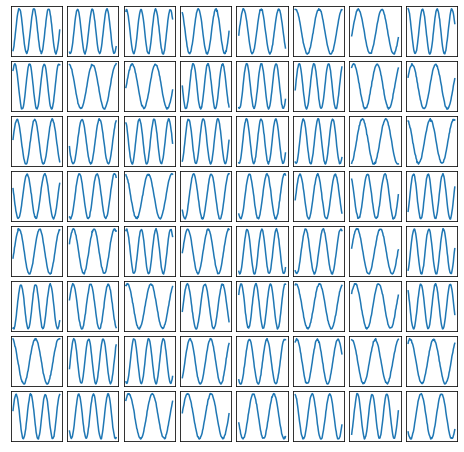

In [ ]:
# Generate synthetic spectra
train_data, mu_real, sig_real, a_real = generate_1DspectraS(sig_min=5, sig_range=9, mu_range=30, noise='rand')

# Initialize dataloader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

# Plot sample data
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

x = torch.linspace(-10, 10, 100)
for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x, y[0, 0])

Instantiate and train the VAE:

In [ ]:
in_dim = (100,) # input dimension

# Initialize regular VAE
vae = pv.models.trVAE(in_dim, latent_dim=2, coord=0, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(100):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 61.6309
Epoch: 2 Training loss: 57.0981
Epoch: 3 Training loss: 55.5398
Epoch: 4 Training loss: 54.0872
Epoch: 5 Training loss: 52.9612
Epoch: 6 Training loss: 52.1021
Epoch: 7 Training loss: 51.5375
Epoch: 8 Training loss: 51.3263
Epoch: 9 Training loss: 50.9644
Epoch: 10 Training loss: 50.7649
Epoch: 11 Training loss: 50.7046
Epoch: 12 Training loss: 50.4601
Epoch: 13 Training loss: 50.2821
Epoch: 14 Training loss: 50.1479
Epoch: 15 Training loss: 50.0889
Epoch: 16 Training loss: 50.0219
Epoch: 17 Training loss: 49.9399
Epoch: 18 Training loss: 49.8153
Epoch: 19 Training loss: 49.8850
Epoch: 20 Training loss: 49.7952
Epoch: 21 Training loss: 49.7818
Epoch: 22 Training loss: 49.7353
Epoch: 23 Training loss: 49.6832
Epoch: 24 Training loss: 49.6140
Epoch: 25 Training loss: 49.5755
Epoch: 26 Training loss: 49.5427
Epoch: 27 Training loss: 49.5286
Epoch: 28 Training loss: 49.5050
Epoch: 29 Training loss: 49.4584
Epoch: 30 Training loss: 49.5113
Epoch: 31 Training 

Plot the latent space distribution:

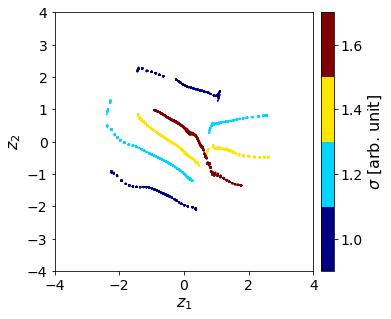

In [ ]:
z_mean, z_sd = vae.encode(train_data)   # encode the data using the trained model
fig, ax = plt.subplots(figsize=(5, 5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sig_np = sig_real.numpy()
shift = (sig_np.max() - sig_np.min()) / len(np.unique(sig_np)) / 2
c = ax.scatter(z_mean[:, -2], z_mean[:, -1], c = sig_real, s=1, cmap=plt.get_cmap('jet', len(np.unique(sig_np))))
cbar = fig.colorbar(c, cax=cax)
cbar.set_ticks(np.linspace(sig_np.min()+shift, sig_np.max()-shift, len(np.unique(sig_np))))
cbar.set_ticklabels(np.unique(sig_np))
ax.set_aspect('equal')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
cax.set_ylabel('$\sigma$ [arb. unit]')
plt.show()

Plot the learned manifold:

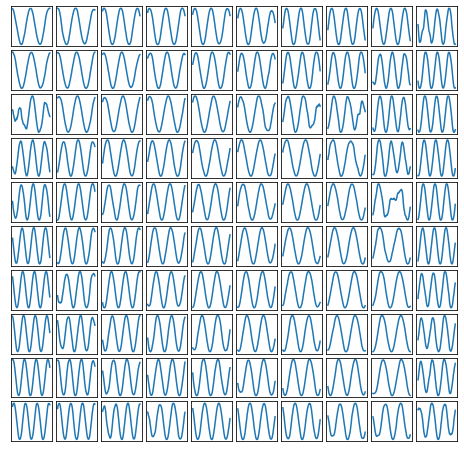

In [ ]:
vae.manifold2d(d=10);

### Regular VAE with $\sigma\in[1,2.4,0.2]$ (Fig. 2 (b) & (e))

Generate 1D data sepctra:

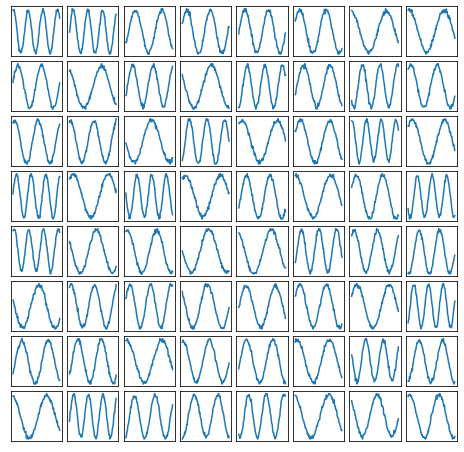

In [ ]:
# Generate synthetic spectra
train_data, mu_real, sig_real, a_real = generate_1DspectraS(sig_min=5, sig_range=13, mu_range=30, noise='rand')

# Initialize dataloader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

# Plot sample data
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

x = torch.linspace(-10, 10, 100)
for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x, y[0, 0])

Instantiate and train the VAE:

In [ ]:
in_dim = (100,) # input dimension

# Initialize regular VAE
vae = pv.models.trVAE(in_dim, latent_dim=2, coord=0, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(100):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 64.5682
Epoch: 2 Training loss: 61.5666
Epoch: 3 Training loss: 60.3369
Epoch: 4 Training loss: 59.2649
Epoch: 5 Training loss: 58.5602
Epoch: 6 Training loss: 58.2646
Epoch: 7 Training loss: 58.0567
Epoch: 8 Training loss: 57.7984
Epoch: 9 Training loss: 57.5033
Epoch: 10 Training loss: 57.2098
Epoch: 11 Training loss: 56.8848
Epoch: 12 Training loss: 56.6308
Epoch: 13 Training loss: 56.5039
Epoch: 14 Training loss: 56.4246
Epoch: 15 Training loss: 56.3945
Epoch: 16 Training loss: 56.2632
Epoch: 17 Training loss: 56.2072
Epoch: 18 Training loss: 56.2058
Epoch: 19 Training loss: 56.1248
Epoch: 20 Training loss: 56.0937
Epoch: 21 Training loss: 56.0302
Epoch: 22 Training loss: 56.0506
Epoch: 23 Training loss: 55.9860
Epoch: 24 Training loss: 56.0065
Epoch: 25 Training loss: 55.9220
Epoch: 26 Training loss: 55.9722
Epoch: 27 Training loss: 55.8929
Epoch: 28 Training loss: 55.8749
Epoch: 29 Training loss: 55.8953
Epoch: 30 Training loss: 55.8457
Epoch: 31 Training 

Plot the latent space distribution:

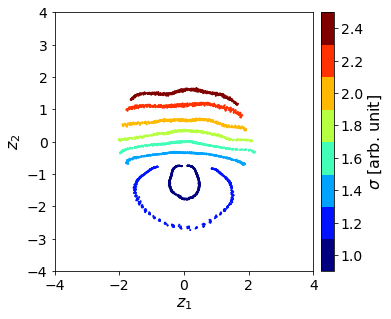

In [ ]:
z_mean, z_sd = vae.encode(train_data)   # encode the data using the trained model
fig, ax = plt.subplots(figsize=(5, 5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sig_np = sig_real.numpy()
shift = (sig_np.max() - sig_np.min()) / len(np.unique(sig_np)) / 2
c = ax.scatter(z_mean[:, -2], z_mean[:, -1], c = sig_real, s=1, cmap=plt.get_cmap('jet', len(np.unique(sig_np))))
cbar = fig.colorbar(c, cax=cax)
cbar.set_ticks(np.linspace(sig_np.min()+shift, sig_np.max()-shift, len(np.unique(sig_np))))
cbar.set_ticklabels(np.unique(sig_np))
ax.set_aspect('equal')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
cax.set_ylabel('$\sigma$ [arb. unit]')
plt.show()

Plot the learned manifold:

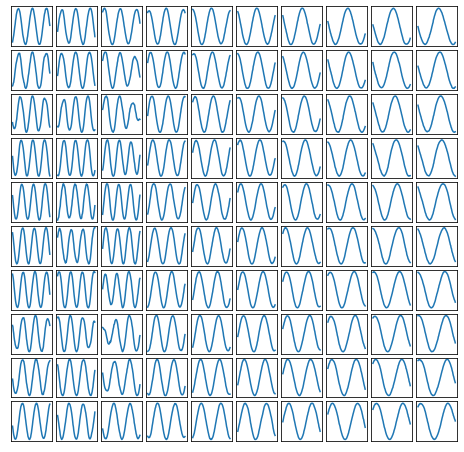

In [ ]:
vae.manifold2d(d=10);

### Shift-VAE with $\sigma\in[1,2.4,0.2]$ (Fig. 2 (c) & (f))

Generate 1D data sepctra:

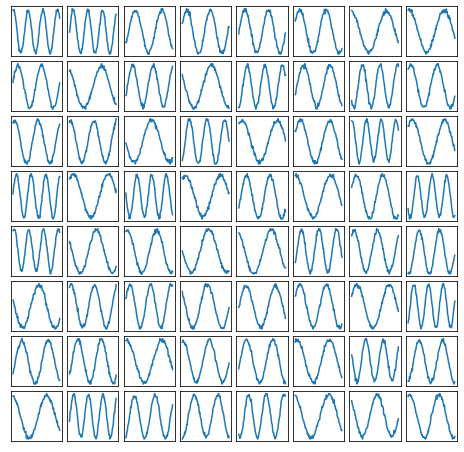

In [ ]:
# Generate synthetic spectra
train_data, mu_real, sig_real, a_real = generate_1DspectraS(sig_min=5, sig_range=13, mu_range=30, noise='rand')

# Initialize dataloader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

# Plot sample data
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

x = torch.linspace(-10, 10, 100)
for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x, y[0, 0])

Instantiate and train the VAE:

In [ ]:
in_dim = (100,) # input dimension

# Initialize regular VAE
vae = pv.models.trVAE(in_dim, latent_dim=2, coord=1, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(100):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 69.0347
Epoch: 2 Training loss: 64.9754
Epoch: 3 Training loss: 62.8675
Epoch: 4 Training loss: 59.6556
Epoch: 5 Training loss: 58.5785
Epoch: 6 Training loss: 58.2458
Epoch: 7 Training loss: 57.9304
Epoch: 8 Training loss: 57.6249
Epoch: 9 Training loss: 57.3177
Epoch: 10 Training loss: 56.9302
Epoch: 11 Training loss: 56.8097
Epoch: 12 Training loss: 56.6895
Epoch: 13 Training loss: 56.5902
Epoch: 14 Training loss: 56.5166
Epoch: 15 Training loss: 56.4913
Epoch: 16 Training loss: 56.5195
Epoch: 17 Training loss: 56.4328
Epoch: 18 Training loss: 56.3768
Epoch: 19 Training loss: 56.3656
Epoch: 20 Training loss: 56.3506
Epoch: 21 Training loss: 56.3173
Epoch: 22 Training loss: 56.3257
Epoch: 23 Training loss: 56.3201
Epoch: 24 Training loss: 56.2967
Epoch: 25 Training loss: 56.2630
Epoch: 26 Training loss: 56.2989
Epoch: 27 Training loss: 56.2353
Epoch: 28 Training loss: 56.2236
Epoch: 29 Training loss: 56.2594
Epoch: 30 Training loss: 56.1988
Epoch: 31 Training 

Plot the latent space distribution:

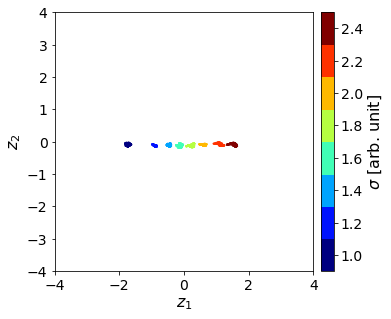

In [ ]:
z_mean, z_sd = vae.encode(train_data)   # encode the data using the trained model
fig, ax = plt.subplots(figsize=(5, 5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sig_np = sig_real.numpy()
shift = (sig_np.max() - sig_np.min()) / len(np.unique(sig_np)) / 2
c = ax.scatter(z_mean[:, -2], z_mean[:, -1], c = sig_real, s=1, cmap=plt.get_cmap('jet', len(np.unique(sig_np))))
cbar = fig.colorbar(c, cax=cax)
cbar.set_ticks(np.linspace(sig_np.min()+shift, sig_np.max()-shift, len(np.unique(sig_np))))
cbar.set_ticklabels(np.unique(sig_np))
ax.set_aspect('equal')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
cax.set_ylabel('$\sigma$ [arb. unit]')
plt.show()

Plot the learned manifold:

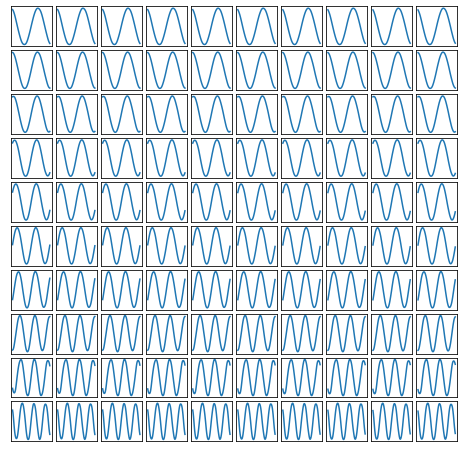

In [ ]:
vae.manifold2d(d=10);

## Sinusoidal fit parameters in the (sh-)VAE latent space (Fig. 3)

In [ ]:
def sinefunction(x, a, b, c, d):
    return d + b * np.sin((x-c)/a)

def sinfit(y):
    x = np.linspace(-10, 10, 100)
    peaks = find_peaks(y)[0]
    # a (sig) is calculated by finding the mean distance between peaks and dividing by 2pi
    try:
        a = np.mean([x[peaks[i+1]] - x[peaks[i]] for i in range(len(find_peaks(y))-1)]) / (2 * np.pi)   # period
    except:
        a = 1
    b = (y.max() - y.min()) / 2 # amplitude
    # c (mu) is calculated by finding the first peak with x > 0 and adding pi/2, then multiplied by a
    try:
        c = -(x[peaks[peaks > np.where(x>=0)[0][0]][0]] + np.pi / 2) * a   # phase
    except:
        c = 0
    d = (y.max() - y.min()) / 2 + y.min() # noise/offset from y=0

    smodel = Model(sinefunction)
    result = smodel.fit(y, x=x, a=a, b=b, c=c, d=d)
    return result.values, result, a, b, c, d

### Fitted parameters in the regular VAE latent space (Fig. 3 (a)–(c))

Generate 1D data and train the VAE:

In [ ]:
# generate data
train_data, mu_real, sig_real, a_real = generate_1DspectraS(sig_min=5, sig_range=12, mu_range=30, noise='rand')
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), 
                                        batch_size=64)
# instantiate and train vae
vae = pv.models.trVAE((100,), latent_dim=2, coord=0, sampler_d="gaussian", 
                      decoder_sig=.1, sigmoid_d=False, seed=0)
trainer = pv.trainers.SVItrainer(vae)
for e in range(100):    # epoch
    trainer.step(train_loader)
z_mean, z_sd = vae.encode(train_data)

Fit sinusoidal parameters over the latent space:

In [ ]:
l1s = torch.from_numpy(np.linspace(-4, 4, num=100)).float()
l2s = torch.from_numpy(np.linspace(-4, 4, num=100)).float()

mu_dec = np.zeros((len(l2s), len(l1s)))    # phase
sig_dec = np.zeros((len(l2s), len(l1s)))   # period
a_dec = np.zeros((len(l2s), len(l1s)))     # amplitude

for i in range(len(l2s)):
    for j in range(len(l1s)):
        l1 = l1s[j]; l2 = l2s[i]; lat_ten = torch.tensor([[l1, l2]])
        data_dec = vae.decode(lat_ten)
        dec_vec = data_dec.cpu().numpy()[0]
        params, _, x, y, z, w = sinfit(dec_vec)
        mu_dec[i, j] = params['c']
        sig_dec[i, j] = params['a']
        a_dec[i, j] = params['b']

Plot the fitted parameter maps:

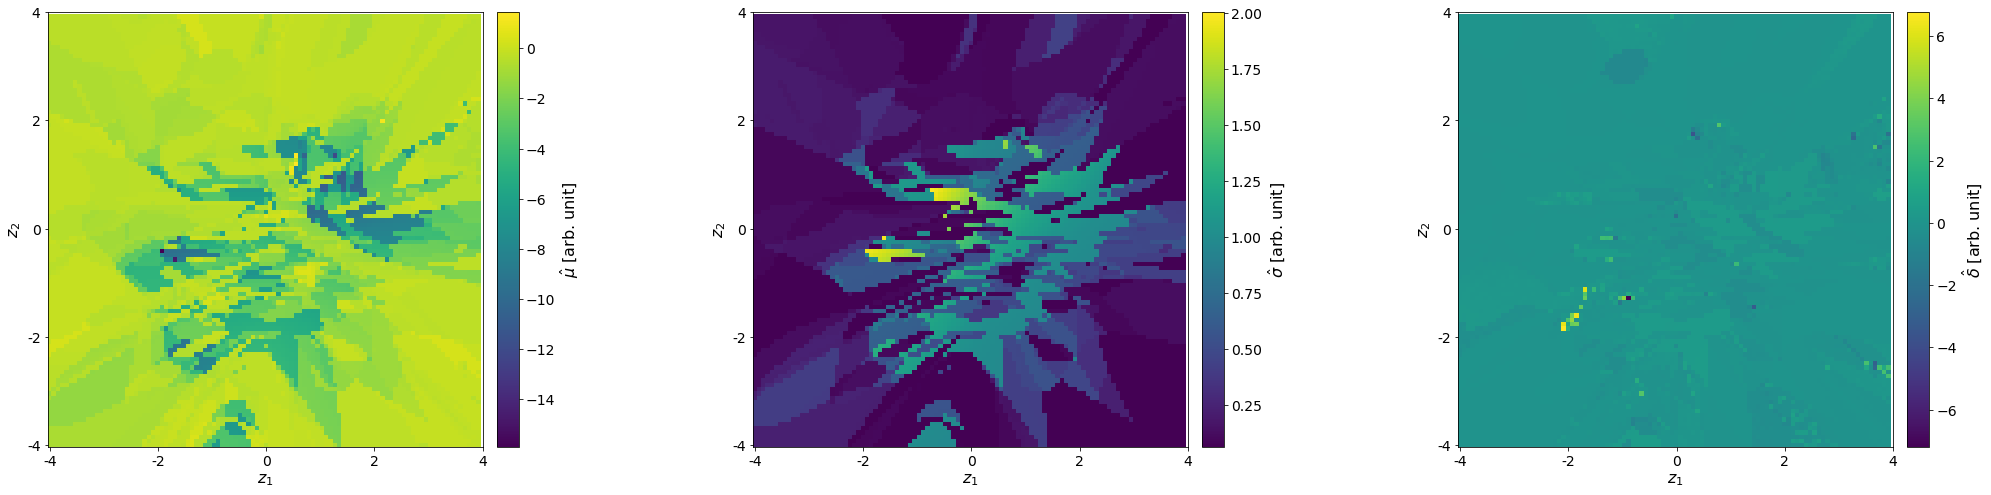

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 8))
plt.subplots_adjust(right=2.9)

c = ax0.pcolormesh(mu_dec)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(c, cax=cax0)
ax0.set_xlabel('$z_1$')
ax0.set_ylabel('$z_2$')
cax0.set_ylabel('$\hat{\mu}$ [arb. unit]')
ax0.set_aspect('equal')
ax0.set_xticks(np.linspace(0, 100, 5)+0.5)
ax0.set_yticks(np.linspace(0, 100, 5)+0.5)
ax0.set_xticklabels(np.linspace(-4, 4, 5, dtype=int))
ax0.set_yticklabels(np.linspace(-4, 4, 5, dtype=int))

c = ax1.pcolormesh(sig_dec)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(c, cax=cax1)
ax1.set_xlabel('$z_1$')
ax1.set_ylabel('$z_2$')
cax1.set_ylabel('$\hat{\sigma}$ [arb. unit]')
ax1.set_aspect('equal')
ax1.set_xticks(np.linspace(0, 100, 5)+0.5)
ax1.set_yticks(np.linspace(0, 100, 5)+0.5)
ax1.set_xticklabels(np.linspace(-4, 4, 5, dtype=int))
ax1.set_yticklabels(np.linspace(-4, 4, 5, dtype=int))

c = ax2.pcolormesh(a_dec)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(c, cax=cax2)
ax2.set_xlabel('$z_1$')
ax2.set_ylabel('$z_2$')
cax2.set_ylabel('$\hat{\delta}$ [arb. unit]')
ax2.set_aspect('equal')
ax2.set_xticks(np.linspace(0, 100, 5)+0.5)
ax2.set_yticks(np.linspace(0, 100, 5)+0.5)
ax2.set_xticklabels(np.linspace(-4, 4, 5, dtype=int))
ax2.set_yticklabels(np.linspace(-4, 4, 5, dtype=int))

plt.show()

### Fitted parameters in the shift-VAE latent space (Fig. 3 (d)–(f))

Generate 1D data and train the VAE:

In [ ]:
# generate data
train_data, mu_real, sig_real, a_real = generate_1DspectraS(sig_min=5, sig_range=12, mu_range=30, noise='rand')
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), 
                                        batch_size=64)
# instantiate and train vae
vae = pv.models.trVAE((100,), latent_dim=2, coord=1, sampler_d="gaussian", 
                      decoder_sig=.1, sigmoid_d=False, seed=0)
trainer = pv.trainers.SVItrainer(vae)
for e in range(100):    # epoch
    trainer.step(train_loader)
z_mean, z_sd = vae.encode(train_data)

Fit sinusoidal parameters over the latent space:

In [ ]:
l1s = torch.from_numpy(np.linspace(-4, 4, num=100)).float()
l2s = torch.from_numpy(np.linspace(-4, 4, num=100)).float()

mu_dec = np.zeros((len(l2s), len(l1s)))    # phase
sig_dec = np.zeros((len(l2s), len(l1s)))   # period
a_dec = np.zeros((len(l2s), len(l1s)))     # amplitude

for i in range(len(l2s)):
    for j in range(len(l1s)):
        l1 = l1s[j]; l2 = l2s[i]; lat_ten = torch.tensor([[l1, l2]])
        data_dec = vae.decode(lat_ten)
        dec_vec = data_dec.cpu().numpy()[0]
        params, _, x, y, z, w = sinfit(dec_vec)
        mu_dec[i, j] = params['c']
        sig_dec[i, j] = params['a']
        a_dec[i, j] = params['b']

Plot the fitted parameter maps:

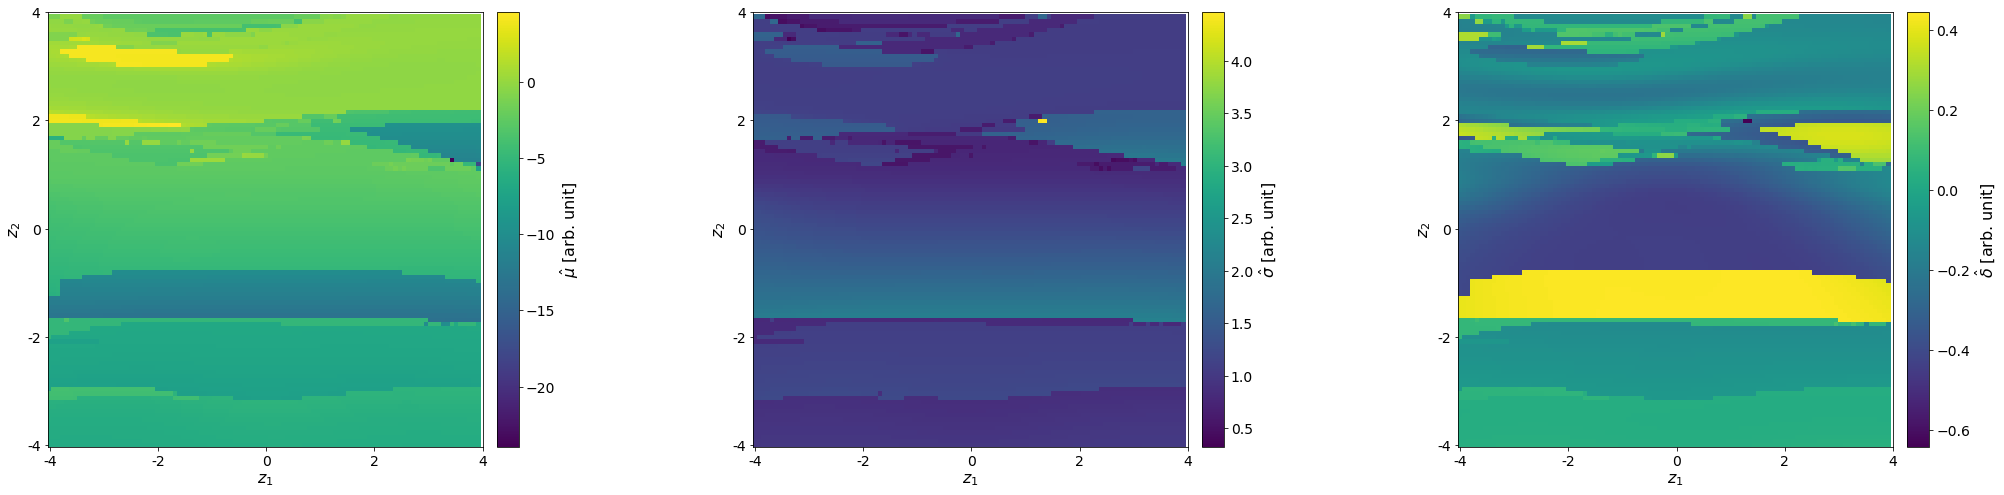

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 8))
plt.subplots_adjust(right=2.9)

c = ax0.pcolormesh(mu_dec)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(c, cax=cax0)
ax0.set_xlabel('$z_1$')
ax0.set_ylabel('$z_2$')
cax0.set_ylabel('$\hat{\mu}$ [arb. unit]')
ax0.set_aspect('equal')
ax0.set_xticks(np.linspace(0, 100, 5)+0.5)
ax0.set_yticks(np.linspace(0, 100, 5)+0.5)
ax0.set_xticklabels(np.linspace(-4, 4, 5, dtype=int))
ax0.set_yticklabels(np.linspace(-4, 4, 5, dtype=int))

c = ax1.pcolormesh(sig_dec)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(c, cax=cax1)
ax1.set_xlabel('$z_1$')
ax1.set_ylabel('$z_2$')
cax1.set_ylabel('$\hat{\sigma}$ [arb. unit]')
ax1.set_aspect('equal')
ax1.set_xticks(np.linspace(0, 100, 5)+0.5)
ax1.set_yticks(np.linspace(0, 100, 5)+0.5)
ax1.set_xticklabels(np.linspace(-4, 4, 5, dtype=int))
ax1.set_yticklabels(np.linspace(-4, 4, 5, dtype=int))

c = ax2.pcolormesh(a_dec)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(c, cax=cax2)
ax2.set_xlabel('$z_1$')
ax2.set_ylabel('$z_2$')
cax2.set_ylabel('$\hat{\delta}$ [arb. unit]')
ax2.set_aspect('equal')
ax2.set_xticks(np.linspace(0, 100, 5)+0.5)
ax2.set_yticks(np.linspace(0, 100, 5)+0.5)
ax2.set_xticklabels(np.linspace(-4, 4, 5, dtype=int))
ax2.set_yticklabels(np.linspace(-4, 4, 5, dtype=int))

plt.show()

### Error in the fit in terms of $\mu$ (Fig. 3 (g) & (h))

Perform grid search over the range of parameters:

In [ ]:
noise = 10 ** (np.linspace(-5, 1, num=21, endpoint=True))
mu_spread = np.linspace(10, 60, num=21, dtype=int)
R2_map = np.zeros((21, 21))
m_map = np.zeros((21, 21))

epochs = 100
for i in range(len(mu_spread)):
    for j in range(len(noise)):
        # generate data
        train_data, mu_real, sig_real, a_real = generate_1DspectraS(mu_range=mu_spread[i], 
                                                                    noise=noise[j])
        train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), 
                                                batch_size=64)
        # instantiate and train vae
        vae = pv.models.trVAE((100,), latent_dim=2, coord=1, 
                              sampler_d="gaussian", decoder_sig=.1, 
                              sigmoid_d=False, seed=0)
        trainer = pv.trainers.SVItrainer(vae)
        for e in range(epochs):
            trainer.step(train_loader)
        z_mean, z_sd = vae.encode(train_data)
        # linear regression
        mu_var = z_mean[:,0].numpy().reshape(-1, 1)
        reg = LinearRegression().fit(mu_var, mu_real)
        R2_map[i, j] = reg.score(mu_var, mu_real)
        m_map[i, j] = reg.coef_

Plot the error maps:

In [ ]:
spread = mu_spread

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 6))

c = ax0.pcolormesh(R2_map)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes("right", size="5%", pad=0.25)
fig.colorbar(c, cax=cax0)
cax0.set_ylabel('R$^2$')
ax0.set_xlabel('Noise [arb. unit]')
ax0.set_ylabel('$\mu$ spread [arb. unit]')
ax0.set_aspect('equal')
ax0.set_xticks(np.linspace(0, 20, 11)+0.5)
ax0.set_yticks(np.linspace(0, 20, 6)+0.5)
ax0.set_xticklabels(noise, rotation=45)
ax0.set_yticklabels(np.linspace(min(spread), max(spread), 6, dtype=int))

c = ax1.pcolormesh(m_map, cmap=plt.get_cmap('seismic', 21), vmin=-10.5, vmax=10.5)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.25)
cbar1 = fig.colorbar(c, cax=cax1)
cbar1.set_ticks(np.linspace(-10, 10, 21))
cbar1.set_ticklabels(['<-10', -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '>10'])
cax1.set_ylabel('$\mu:\hat{\mu}$ [arb. unit]')
ax1.set_xlabel('Noise [arb. unit]')
ax1.set_ylabel('$\mu$ spread [arb. unit]')
ax1.set_aspect('equal')
ax1.set_xticks(np.linspace(0, 20, 11)+0.5)
ax1.set_yticks(np.linspace(0, 20, 6)+0.5)
ax1.set_xticklabels(noise, rotation=45)
ax1.set_yticklabels(np.linspace(min(spread), max(spread), 6, dtype=int))

plt.subplots_adjust(right=1.5) # for horizontal layout
plt.show()

### Error in the fit in terms of $\sigma$

Perform grid search over the range of parameters:

In [ ]:
noise = 10 ** (np.linspace(-5, 1, num=21, endpoint=True))
sig_spread = np.linspace(15, 60, num=21, dtype=int)
R2_map = np.zeros((21, 21))
m_map = np.zeros((21, 21))
epochs = 100
for i in range(len(sig_spread)):
    for j in range(len(noise)):
        # generate data
        train_data, mu_real, sig_real, a_real = generate_1DspectraS(sig_range=sig_spread[i], 
                                                                    noise=noise[j])
        train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), 
                                                batch_size=64)
        # instantiate and train vae
        vae = pv.models.trVAE((100,), latent_dim=2, coord=1, 
                              sampler_d="gaussian", decoder_sig=.1, 
                              sigmoid_d=False, seed=0)
        trainer = pv.trainers.SVItrainer(vae)
        for e in range(epochs):
            trainer.step(train_loader)
        z_mean, z_sd = vae.encode(train_data)
        # linear regression
        sig_var = z_mean[:,2].numpy().reshape(-1, 1)
        reg = LinearRegression().fit(sig_var, sig_real)
        R2_map[i, j] = reg.score(sig_var, sig_real)
        m_map[i, j] = reg.coef_

Plot the error maps:

In [ ]:
spread = sig_spread

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 6))

c = ax0.pcolormesh(R2_map)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes("right", size="5%", pad=0.25)
fig.colorbar(c, cax=cax0)
cax0.set_ylabel('R$^2$')
ax0.set_xlabel('Noise [arb. unit]')
ax0.set_ylabel('$\sig$ spread [arb. unit]')
ax0.set_aspect('equal')
ax0.set_xticks(np.linspace(0, 20, 11)+0.5)
ax0.set_yticks(np.linspace(0, 20, 6)+0.5)
ax0.set_xticklabels(noise, rotation=45)
ax0.set_yticklabels(np.linspace(min(spread), max(spread), 6, dtype=int))

c = ax1.pcolormesh(m_map, cmap=plt.get_cmap('seismic', 21), vmin=-10.5, vmax=10.5)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.25)
cbar1 = fig.colorbar(c, cax=cax1)
cbar1.set_ticks(np.linspace(-10, 10, 21))
cbar1.set_ticklabels(['<-10', -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '>10'])
cax1.set_ylabel('$\sig:\hat{\sig}$ [arb. unit]')
ax1.set_xlabel('Noise [arb. unit]')
ax1.set_ylabel('$\sig$ spread [arb. unit]')
ax1.set_aspect('equal')
ax1.set_xticks(np.linspace(0, 20, 11)+0.5)
ax1.set_yticks(np.linspace(0, 20, 6)+0.5)
ax1.set_xticklabels(noise, rotation=45)
ax1.set_yticklabels(np.linspace(min(spread), max(spread), 6, dtype=int))

plt.subplots_adjust(right=1.5) # for horizontal layout
plt.show()

### Error in the fit in terms of $\delta$

Perform grid search over the range of parameters:

In [ ]:
noise = 10 ** (np.linspace(-5, 1, num=21, endpoint=True))
a_spread = np.linspace(2000, 12000, num=21, dtype=int)
R2_map = np.zeros((21, 21))
m_map = np.zeros((21, 21))
epochs = 100
for i in range(len(a_spread)):
    for j in range(len(noise)):
        # generate data
        train_data, mu_real, sig_real, a_real = generate_1DspectraS(a_range=a_spread[i], 
                                                                    noise=noise[j])
        train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), 
                                                batch_size=64)
        # instantiate and train vae
        vae = pv.models.trVAE((100,), latent_dim=2, coord=1, 
                              sampler_d="gaussian", decoder_sig=.1, 
                              sigmoid_d=False, seed=0)
        trainer = pv.trainers.SVItrainer(vae)
        for e in range(epochs):
            trainer.step(train_loader)
        z_mean, z_sd = vae.encode(train_data)
        # linear regression
        a_var = z_mean[:,1].numpy().reshape(-1, 1)
        reg = LinearRegression().fit(a_var, a_real)
        R2_map[i, j] = reg.score(a_var, a_real)
        m_map[i, j] = reg.coef_

Plot the error maps:

In [ ]:
spread = a_spread

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 6))

c = ax0.pcolormesh(R2_map)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes("right", size="5%", pad=0.25)
fig.colorbar(c, cax=cax0)
cax0.set_ylabel('R$^2$')
ax0.set_xlabel('Noise [arb. unit]')
ax0.set_ylabel('$\delta$ spread [arb. unit]')
ax0.set_aspect('equal')
ax0.set_xticks(np.linspace(0, 20, 11)+0.5)
ax0.set_yticks(np.linspace(0, 20, 6)+0.5)
ax0.set_xticklabels(noise, rotation=45)
ax0.set_yticklabels(np.linspace(min(spread), max(spread), 6, dtype=int))

c = ax1.pcolormesh(m_map, cmap=plt.get_cmap('seismic', 21), vmin=-10.5, vmax=10.5)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.25)
cbar1 = fig.colorbar(c, cax=cax1)
cbar1.set_ticks(np.linspace(-10, 10, 21))
cbar1.set_ticklabels(['<-10', -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '>10'])
cax1.set_ylabel('$\delta:\hat{\delta}$ [arb. unit]')
ax1.set_xlabel('Noise [arb. unit]')
ax1.set_ylabel('$\delta$ spread [arb. unit]')
ax1.set_aspect('equal')
ax1.set_xticks(np.linspace(0, 20, 11)+0.5)
ax1.set_yticks(np.linspace(0, 20, 6)+0.5)
ax1.set_xticklabels(noise, rotation=45)
ax1.set_yticklabels(np.linspace(min(spread), max(spread), 6, dtype=int))

plt.subplots_adjust(right=1.5) # for horizontal layout
plt.show()